In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# print(np.std([3.10,2.19,2.95,2.46,2.44,2.63]))
# print(np.std([0.13,0.09,0.13,0.10,0.10,0.11]))
#print(np.std([15.51,8.29,14.03,21.21,10.04,13.816]))
#print(np.std([0.75,0.395,0.673,1.06,0.487,0.673]))
#print(np.std([0.64,0.41,0.432,0.58,0.56]))
print(np.std([14.32,10.30,12.66,10.93,9.10]))

1.8338854926085215


In [24]:
from scipy import stats
a1 =  [18.44, 16.93 , 33.77 , 12.73 , 16.61]
a2 =  [14.32 , 10.30 ,12.66 ,10.93 ,9.10]
stats.ttest_ind(a1,a2, equal_var = True)

Ttest_indResult(statistic=2.192150876051452, pvalue=0.05972037638740291)

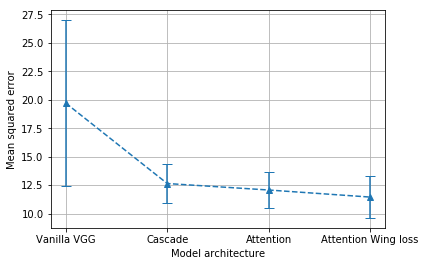

In [18]:
plt.errorbar(["Vanilla VGG","Cascade","Attention","Attention Wing loss"],[19.70,12.64,12.07,11.45],[7.28,1.71,1.62,1.83],label='Mean squared error',linestyle='--', marker='^',capsize=5)
plt.xlabel("Model architecture")
plt.ylabel("Mean squared error")
plt.grid()
plt.savefig('landmark_localization_graph.jpg')
plt.show()

In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15157107598367516926, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16043448730
 locality {
   bus_id: 1
 }
 incarnation: 5178195020429909551
 physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:00:05.0, compute capability: 6.1"]

In [13]:
!git status

On branch master
Your branch is up-to-date with 'origin/master'.
Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)
  (commit or discard the untracked or modified content in submodules)

	deleted:    images/caught lobster/10. pastedimage-44666-310x415.png
	deleted:    images/caught lobster/114. lobster.jpeg-224x300.png
	deleted:    images/caught lobster/132. 20150755b11d16304ca.png
	deleted:    images/caught lobster/137. image.ash
	deleted:    images/caught lobster/191. image.ash
	deleted:    images/caught lobster/192. yellow-lobsterjpg
	deleted:    images/caught lobster/198. albinolobster.alb
	deleted:    images/caught lobster/203. worldslargestlobster_2_jpg
	deleted:    images/caught lobster/208. rlandtag1-sm.png
	deleted:    images/caught lobster/224. splitter-e1351726477989.png
	deleted:    images/caught lobster/290. image.ash
	deleted:    images/caught lobster/34

In [3]:
with open('data-localize0.pckl','rb') as file:
    train_images,train_bboxes,train_labels,train_image_sizes,test_images,test_bboxes,test_labels,test_image_sizes = pickle.load(file)

In [4]:
#num_labels = len(np.unique(labels))

def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou    

In [27]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions


base_model = ResNet50(
    input_shape=(224,224,3),
    weights='imagenet',
    include_top=True
)

cnn_base = Model(
    inputs=base_model.input,
    outputs=base_model.layers[-2].output
)
# to freeze layers
for layer in cnn_base.layers:
    layer.trainable = False

In [28]:
cnn_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [33]:
x = cnn_base.get_layer('activation_284').output
x = Conv2D(2048, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = BatchNormalization()(x)
x = Conv2D(4, kernel_size=(1, 1), padding="same")(x)
x = Reshape((4,),name='localization_output')(x)


y = base_model.layers[-1].output
y = BatchNormalization()(y)
y = Dense(2048,activation='relu')(y)
y = BatchNormalization()(y)
y = Dense(test_labels.shape[1],activation='softmax',name='classification_output')(y)

losses = {
    "localization_output": "mean_squared_error",
    "classification_output": "categorical_crossentropy",
}
lossWeights = {"localization_output": 1.0, "classification_output": 1}

model = Model(inputs=cnn_base.input, outputs=[x,y])
model.compile(loss=losses, optimizer="adam", metrics={'classification_output':'accuracy', 'localization_output':['accuracy',iou_metric]})
#model.compile(loss='categorical_crossentropy', optimizer="adam", metrics={'classification_output':'accuracy'})
model.save_weights('resnet-localization-weights.hd5')

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [35]:
train_pred = []
test_pred = []

train_scores = []
test_scores = []

history_record = []

for i in range(5):
    print("Loading file")
    with open('data-localize'+str(i)+'.pckl','rb') as file:
        train_images,train_bboxes,train_labels,train_image_sizes,test_images,test_bboxes,test_labels,test_image_sizes = pickle.load(file)
    try:
        model.load_weights('resnet-localization'+str(i)+'.hd5')
    except:
        model.load_weights('resnet-localization-weights.hd5')
    print("loaded")
    history = model.fit(x=np.array(train_images),y={"classification_output": np.array(train_labels), "localization_output": np.array(train_bboxes)},batch_size=10,epochs=30,
                       validation_data=(np.array(test_images),{"classification_output": test_labels, "localization_output": np.array(test_bboxes)}))
    history_record.append(history)
    train_score = model.evaluate(x=np.array(train_images),y={"classification_output": np.array(train_labels), "localization_output": np.array(train_bboxes)},batch_size=50)
    test_score = model.evaluate(x=np.array(test_images),y={"classification_output": test_labels, "localization_output": np.array(test_bboxes)},batch_size=50)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print("predicting")
    print("Test Score",test_score)
    train_predictions = model.predict(x=np.array(train_images),batch_size=50)
    test_predictions = model.predict(x=np.array(test_images),batch_size=50)
    
    train_pred.append(train_predictions)
    test_pred.append(test_predictions)
    model.save_weights('resnet-localization'+str(i)+'.hd5')

Loading file
loaded
Train on 7752 samples, validate on 647 samples
Epoch 1/30
7752/7752 [==============================] - 66s 8ms/step - loss: 5022.7327 - localization_output_loss: 5022.0917 - classification_output_loss: 0.6410 - localization_output_acc: 0.6367 - localization_output_iou_metric: 0.3576 - classification_output_acc: 0.8367 - val_loss: 1341.2818 - val_localization_output_loss: 1340.2529 - val_classification_output_loss: 1.0290 - val_localization_output_acc: 0.7264 - val_localization_output_iou_metric: 0.4311 - val_classification_output_acc: 0.6739
Epoch 2/30
7752/7752 [==============================] - 60s 8ms/step - loss: 1130.5056 - localization_output_loss: 1130.0029 - classification_output_loss: 0.5027 - localization_output_acc: 0.7228 - localization_output_iou_metric: 0.5131 - classification_output_acc: 0.8584 - val_loss: 1097.2037 - val_localization_output_loss: 1096.0588 - val_classification_output_loss: 1.1449 - val_localization_output_acc: 0.7527 - val_localizati

Epoch 3/30
7755/7755 [==============================] - 59s 8ms/step - loss: 903.8476 - localization_output_loss: 902.2454 - classification_output_loss: 1.6022 - localization_output_acc: 0.7626 - localization_output_iou_metric: 0.5564 - classification_output_acc: 0.2326 - val_loss: 859.0396 - val_localization_output_loss: 857.4366 - val_classification_output_loss: 1.6030 - val_localization_output_acc: 0.7724 - val_localization_output_iou_metric: 0.4984 - val_classification_output_acc: 0.2539
Epoch 4/30
7755/7755 [==============================] - 59s 8ms/step - loss: 790.2603 - localization_output_loss: 788.6586 - classification_output_loss: 1.6017 - localization_output_acc: 0.7706 - localization_output_iou_metric: 0.5729 - classification_output_acc: 0.2368 - val_loss: 901.3406 - val_localization_output_loss: 899.7384 - val_classification_output_loss: 1.6021 - val_localization_output_acc: 0.7291 - val_localization_output_iou_metric: 0.4935 - val_classification_output_acc: 0.2539
Epoch 

Epoch 5/30
7755/7755 [==============================] - 60s 8ms/step - loss: 630.6560 - localization_output_loss: 630.0319 - classification_output_loss: 0.6241 - localization_output_acc: 0.7840 - localization_output_iou_metric: 0.5866 - classification_output_acc: 0.8233 - val_loss: 1386.8353 - val_localization_output_loss: 1386.0705 - val_classification_output_loss: 0.7649 - val_localization_output_acc: 0.7492 - val_localization_output_iou_metric: 0.5292 - val_classification_output_acc: 0.7229
Epoch 6/30
7755/7755 [==============================] - 60s 8ms/step - loss: 563.4446 - localization_output_loss: 562.8296 - classification_output_loss: 0.6149 - localization_output_acc: 0.7926 - localization_output_iou_metric: 0.5983 - classification_output_acc: 0.8244 - val_loss: 1356.0374 - val_localization_output_loss: 1355.4152 - val_classification_output_loss: 0.6223 - val_localization_output_acc: 0.7477 - val_localization_output_iou_metric: 0.5246 - val_classification_output_acc: 0.8019
Ep

Epoch 7/30
7755/7755 [==============================] - 60s 8ms/step - loss: 581.6821 - localization_output_loss: 581.0980 - classification_output_loss: 0.5841 - localization_output_acc: 0.7997 - localization_output_iou_metric: 0.6002 - classification_output_acc: 0.8347 - val_loss: 935.9659 - val_localization_output_loss: 935.2963 - val_classification_output_loss: 0.6696 - val_localization_output_acc: 0.7724 - val_localization_output_iou_metric: 0.4912 - val_classification_output_acc: 0.7786
Epoch 8/30
7755/7755 [==============================] - 60s 8ms/step - loss: 524.4517 - localization_output_loss: 523.8773 - classification_output_loss: 0.5745 - localization_output_acc: 0.8147 - localization_output_iou_metric: 0.6108 - classification_output_acc: 0.8400 - val_loss: 816.1114 - val_localization_output_loss: 815.4711 - val_classification_output_loss: 0.6403 - val_localization_output_acc: 0.7601 - val_localization_output_iou_metric: 0.5160 - val_classification_output_acc: 0.7833
Epoch 

Epoch 9/30
7755/7755 [==============================] - 61s 8ms/step - loss: 448.1658 - localization_output_loss: 447.6007 - classification_output_loss: 0.5651 - localization_output_acc: 0.8197 - localization_output_iou_metric: 0.6235 - classification_output_acc: 0.8406 - val_loss: 1128.6024 - val_localization_output_loss: 1127.8926 - val_classification_output_loss: 0.7098 - val_localization_output_acc: 0.7198 - val_localization_output_iou_metric: 0.5044 - val_classification_output_acc: 0.7260
Epoch 10/30
7755/7755 [==============================] - 61s 8ms/step - loss: 436.9651 - localization_output_loss: 436.4043 - classification_output_loss: 0.5608 - localization_output_acc: 0.8155 - localization_output_iou_metric: 0.6234 - classification_output_acc: 0.8410 - val_loss: 1125.6648 - val_localization_output_loss: 1124.9935 - val_classification_output_loss: 0.6713 - val_localization_output_acc: 0.7136 - val_localization_output_iou_metric: 0.4992 - val_classification_output_acc: 0.7632
E

In [36]:
historys = []
for hist in history_record:
    historys.append(hist.history)

In [40]:
with open('resnet-predictions.pckl','wb') as file:
    pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)

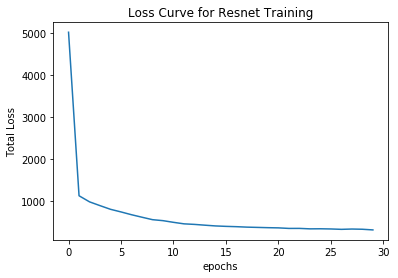

In [55]:
plt.plot(historys[0]['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.title("Loss Curve for Resnet Training")
plt.savefig('Loss_curve_resnet.jpg')
plt.show()

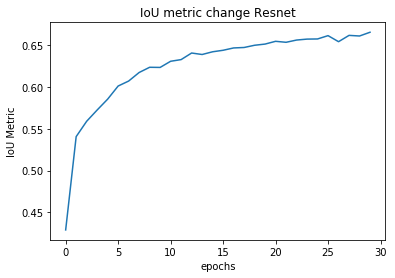

In [64]:
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.title('IoU metric change Resnet')
plt.savefig('IoU_Metric_Resnet.jpg')
plt.show()

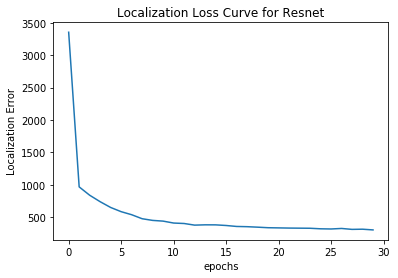

In [66]:
plt.plot(history.history['localization_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Localization Error')
plt.title('Localization Loss Curve for Resnet')
plt.savefig('Localization_Loss_Resnet.jpg')
plt.show()

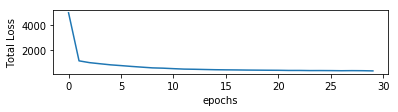

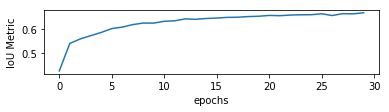

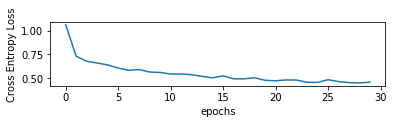

In [46]:
plt.subplot(3,1,1)
plt.plot(historys[0]['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()
plt.savefig("")

In [65]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

In [22]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


IndexError: list index out of range

In [ ]:
# print(np.mean(np.array(test_cvscores)[:,1]))
# print(np.std(np.array(test_cvscores)[:,1]))

# print(np.mean(np.array(validation_cvscores)[:,1]))
# print(np.std(np.array(validation_cvscores)[:,1]))

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [108]:
with open('data-localize'+str(2)+'.pckl','rb') as file:
        train_images,train_bboxes,train_labels,train_image_sizes,test_images,test_bboxes,test_labels,test_image_sizes = pickle.load(file)
predicted_labels = le.inverse_transform(np.argmax(test_pred[2][1],axis=1))
true_labels = le.inverse_transform(np.argmax(test_labels.toarray(),axis=1))


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [109]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels,labels=np.unique(predicted_labels))
print(cm)

[[140   0   9   0   1]
 [  5  94   1   0   3]
 [ 24   1  80   5   0]
 [ 41   1  26  92   1]
 [  4   2   4   0 112]]


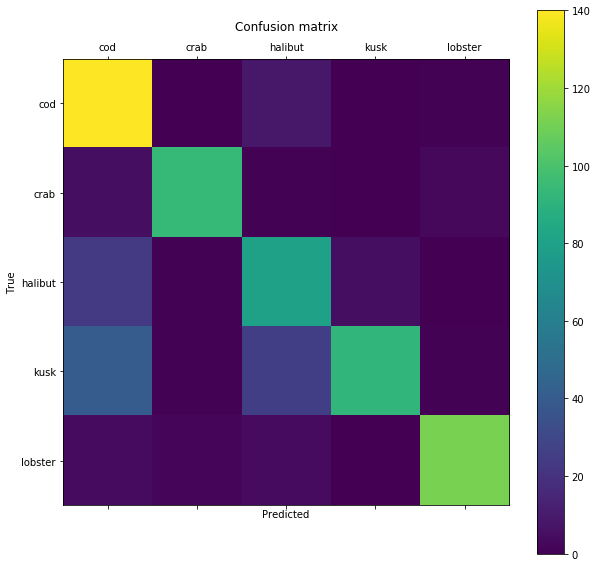

In [110]:
confusion_matrix(true_labels, predicted_labels)

labels_ = np.unique(predicted_labels)
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels(['']+list(labels_))
ax.set_yticklabels(['']+list(labels_))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('Confusion Matrix Resnet.jpg')
plt.show()

In [92]:
labels_

array(['cod', 'crab', 'halibut', 'kusk', 'lobster'], dtype='<U7')